In [2]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 1.2 MB/s eta 0:00:00a 0:00:04
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 1.2 MB/s eta 0:00:00a 0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.2 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [fonttools]


In [3]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer
import pandas as pd
import numpy as np
from torch.utils.data import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time

/home/injeolmi/.conda/envs/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import BertTokenizer
import pandas as pd
from tqdm import tqdm

def dataPreprocessFromTXT(filename, input_ids, input_types, input_masks, labels):
    pad_size = 200
    # 로컬 vocab.txt 경로 지정
    tokenizer = BertTokenizer(
        vocab_file="../../bert_tokenizer/vocab.txt",
        do_lower_case=True
    )

    df = pd.read_csv(
        filename,
        sep="\t", header=None,
        names=["label","url"],
        encoding="utf-8"
    )
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Preprocess {filename}"):
        url = row["url"]
        y   = row["label"]

        tokens = tokenizer.tokenize(url)
        tokens = ["[CLS]"] + tokens + ["[SEP]"]

        ids   = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        types = [0] * len(ids)

        if len(ids) < pad_size:
            pad_len = pad_size - len(ids)
            ids   += [0] * pad_len
            masks += [0] * pad_len
            types += [0] * pad_len
        else:
            ids   = ids[:pad_size]
            masks = masks[:pad_size]
            types = types[:pad_size]

        input_ids.append(ids)
        input_masks.append(masks)
        input_types.append(types)

        # 5) 레이블 매핑: 문자열 'benign'→0, 'malicious'→1 (정수 0/2도 처리)
        y_str = str(y).lower()
        if y_str in ("benign", "0"):
            labels.append(0)
        elif y_str in ("malicious", "2"):
            labels.append(1)
        else:
            raise ValueError(f"Unknown label: {y}")

In [ ]:
# 학습용(Train)
train_ids, train_types, train_masks, train_labels = [], [], [], []
dataPreprocessFromTXT("../../dataset/train.txt",
                      train_ids, train_types, train_masks, train_labels)

# 검증용(Validation)
val_ids, val_types, val_masks, val_labels = [], [], [], []
dataPreprocessFromTXT("../../dataset/test.txt",
                      val_ids, val_types, val_masks, val_labels)
//train,val-train.txt, test-test.txt 사용 하기 


Preprocess ../../dataset/test.txt: 100%|██████████| 20000/20000 [00:04<00:00, 4287.73it/s]


In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [6]:
def spiltDatast_bert(input_ids, input_types, input_masks, label):
    """
    Split the dataset into training and testing sets.

    :param input_ids: List of input character IDs.
    :param input_types: List of segment IDs.
    :param input_masks: List of attention masks.
    :param label: List of labels.
    :return: Split datasets for training and testing.
    """
    # Randomly shuffle the indices
    random_order = list(range(len(input_ids)))
    np.random.seed(2024)  # Fix the seed
    np.random.shuffle(random_order)
    print(random_order[:10])

    # Split the dataset into 80% training and 20% testing
    input_ids_train = np.array([input_ids[i] for i in random_order[:int(len(input_ids) * 0.8)]])
    input_types_train = np.array([input_types[i] for i in random_order[:int(len(input_ids) * 0.8)]])
    input_masks_train = np.array([input_masks[i] for i in random_order[:int(len(input_ids) * 0.8)]])
    y_train = np.array([label[i] for i in random_order[:int(len(input_ids) * 0.8)]])
    print("input_ids_train.shape:" + str(input_ids_train.shape))
    print("input_types_train.shape:" + str(input_types_train.shape))
    print("input_masks_train.shape:" + str(input_masks_train.shape))
    print("y_train.shape:" + str(y_train.shape))

    input_ids_test = np.array([input_ids[i] for i in random_order[int(len(input_ids) * 0.8):int(len(input_ids) * 1)]])
    input_types_test = np.array([input_types[i] for i in random_order[int(len(input_ids) * 0.8):int(len(input_ids) * 1)]])
    input_masks_test = np.array([input_masks[i] for i in random_order[int(len(input_ids) * 0.8):int(len(input_ids) * 1)]])
    y_test = np.array([label[i] for i in random_order[int(len(input_ids) * 0.8):int(len(input_ids) * 1)]])
    print("input_ids_test.shape:" + str(input_ids_test.shape))
    print("input_types_test.shape:" + str(input_types_test.shape))
    print("input_masks_test.shape:" + str(input_masks_test.shape))
    print("y_test.shape:" + str(y_test.shape))

    return input_ids_train, input_types_train, input_masks_train, y_train, input_ids_test, input_types_test, input_masks_test, y_test


In [7]:
print(len(train_ids))
print(len(train_labels))


79998
79998


In [8]:
input_ids_train, input_types_train, input_masks_train, y_train, input_ids_val, input_types_val, input_masks_val, y_val = spiltDatast_bert(
    train_ids, train_types, train_masks, train_labels
)

BATCH_SIZE = 64
train_data = TensorDataset(torch.tensor(input_ids_train).to(DEVICE),
                               torch.tensor(input_types_train).to(DEVICE),
                               torch.tensor(input_masks_train).to(DEVICE),
                               torch.tensor(y_train).to(DEVICE))
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(torch.tensor(input_ids_val).to(DEVICE),
                              torch.tensor(input_types_val).to(DEVICE),
                              torch.tensor(input_masks_val).to(DEVICE),
                              torch.tensor(y_val).to(DEVICE))
val_sampler = SequentialSampler(val_data)
val_loader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

[54744, 26671, 24586, 5189, 17246, 41963, 19535, 24723, 71407, 5982]
input_ids_train.shape:(63998, 200)
input_types_train.shape:(63998, 200)
input_masks_train.shape:(63998, 200)
y_train.shape:(63998,)
input_ids_test.shape:(16000, 200)
input_types_test.shape:(16000, 200)
input_masks_test.shape:(16000, 200)
y_test.shape:(16000,)


In [9]:
from transformers import (
    AutoConfig,
    AutoModelForMaskedLM,
)

config_kwargs = {
    "cache_dir": None,
    "revision": 'main',
    "use_auth_token": None,
    "hidden_dropout_prob": 0.1,
    "vocab_size": 5000,
}

config = AutoConfig.from_pretrained("../../bert_config", **config_kwargs)
print(config)

bert_model = AutoModelForMaskedLM.from_config(
    config=config,
)
bert_model.resize_token_embeddings(config_kwargs["vocab_size"])
print(bert_model)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 5000
}

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (l

In [10]:
bert_model.load_state_dict(
    torch.load("../../bert_model/urlBERT (1).pt", map_location="cpu"),
    strict=False
)



<All keys matched successfully>

In [11]:
class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, freeze=False):
        super(BertForSequenceClassification, self).__init__()
        self.bert = bert
        for name, param in self.bert.named_parameters():
            param.requires_grad = True
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(768, 2)

    def forward(self, x):
        context = x[0]
        types = x[1]
        mask = x[2]
        outputs = self.bert(context, attention_mask=mask, token_type_ids=types, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1][:,0,:]
        out = self.dropout(hidden_states)
        out = self.classifier(out)
        
        return out

In [12]:
model = BertForSequenceClassification(bert_model)
model.bert.cls = nn.Sequential()
model.to(DEVICE)

BertForSequenceClassification(
  (bert): BertForMaskedLM(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(5000, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=7

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)

In [14]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (x1, x2, x3, y) in enumerate(train_loader):
        start_time = time.time()
        x1, x2, x3, y = x1.to(device), x2.to(device), x3.to(device), y.to(device)
        
        y_pred = model([x1, x2, x3])
        model.zero_grad()
        
        loss = F.cross_entropy(y_pred, y.squeeze())
        loss.backward()
        
        optimizer.step()
        if (batch_idx + 1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.2f}%)]\t Loss: {:.6f}'.format(epoch, (batch_idx + 1) * len(x1),
                                                                            len(train_loader.dataset),
                                                                            100. * batch_idx / len(train_loader),
                                                                            loss.item()))


In [15]:
def validation(model, device, test_loader):
    """
    Perform model validation on the test data.

    :param model: The model to be validated.
    :param device: The device to run validation on (e.g., CPU or GPU).
    :param test_loader: The data loader for test data.
    :return: A tuple containing accuracy, precision, recall, and F1 score.
    """
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []

    for batch_idx, (x1, x2, x3, y) in enumerate(test_loader):
        x1, x2, x3, y = x1.to(device), x2.to(device), x3.to(device), y.to(device)
        with torch.no_grad():
            y_ = model([x1, x2, x3])

        test_loss += F.cross_entropy(y_, y.squeeze()).item()

        pred = y_.max(-1, keepdim=True)[1]  # .max(): 2 outputs, representing the maximum value and its index

        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

    test_loss /= len(test_loader)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['benign', 'malware'],
                yticklabels=['benign', 'malware'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Save the confusion matrix plot
    plt.savefig('confusion_matrix.png')

    print('Test set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%, F1: {:.2f}%'.format(
        test_loss, accuracy * 100, precision * 100, recall * 100, f1 * 100))

    return accuracy, precision, recall, f1


In [16]:
torch.cuda.empty_cache()

In [17]:
import os

# 프로젝트 폴더 안에 "checkpoints" 디렉터리를 만들기
os.makedirs("checkpoints", exist_ok=True)

Train Epoch: 1 [6400/63998 (9.90%)]	 Loss: 0.000985
Train Epoch: 1 [12800/63998 (19.90%)]	 Loss: 0.057148
Train Epoch: 1 [19200/63998 (29.90%)]	 Loss: 0.000896
Train Epoch: 1 [25600/63998 (39.90%)]	 Loss: 0.022125
Train Epoch: 1 [32000/63998 (49.90%)]	 Loss: 0.005868
Train Epoch: 1 [38400/63998 (59.90%)]	 Loss: 0.000718
Train Epoch: 1 [44800/63998 (69.90%)]	 Loss: 0.004419
Train Epoch: 1 [51200/63998 (79.90%)]	 Loss: 0.000560
Train Epoch: 1 [57600/63998 (89.90%)]	 Loss: 0.065237
Train Epoch: 1 [62000/63998 (99.90%)]	 Loss: 0.156866
Test set: Average loss: 0.0230, Accuracy: 99.24%, Precision: 98.71%, Recall: 99.80%, F1: 99.25%
acc is: 0.9924, best acc is 0.9924
Train Epoch: 2 [6400/63998 (9.90%)]	 Loss: 0.000508
Train Epoch: 2 [12800/63998 (19.90%)]	 Loss: 0.000564
Train Epoch: 2 [19200/63998 (29.90%)]	 Loss: 0.000379
Train Epoch: 2 [25600/63998 (39.90%)]	 Loss: 0.007902
Train Epoch: 2 [32000/63998 (49.90%)]	 Loss: 0.058860


KeyboardInterrupt: 

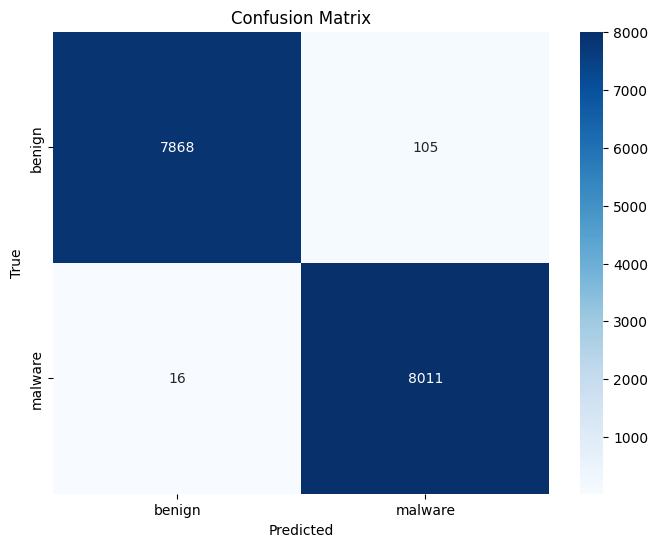

In [18]:
best_acc = 0.0
NUM_EPOCHS = 3
PATH = "checkpoints/modelx_URLBERT_80.pth"
for epoch in range(1, NUM_EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    acc, precision, recall, f1 = validation(model, DEVICE, val_loader)
    if best_acc < acc:
        best_acc = acc
        torch.save(model.state_dict(), PATH)
    print("acc is: {:.4f}, best acc is {:.4f}".format(acc, best_acc))

In [40]:
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModelForMaskedLM, BertTokenizer
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────────────────────────────────────────────────────────────────────
# 1) 토크나이저 로드 (vocab.txt 위치가 맞아야 합니다)
# ─────────────────────────────────────────────────────────────────────────
tokenizer = BertTokenizer(
    vocab_file="../../bert_tokenizer/vocab.txt",
    do_lower_case=True
)

# ─────────────────────────────────────────────────────────────────────────
# 2) 베이스 BERT 모델(사전학습된 MaskedLM) 불러오기
#    – config.json 을 AutoConfig.from_pretrained 로 읽어 옵니다.
# ─────────────────────────────────────────────────────────────────────────
config = AutoConfig.from_pretrained(
    "../../bert_config",   # 이 폴더 안에 config.json 이 있어야 함
    hidden_dropout_prob=0.1,
    vocab_size=tokenizer.vocab_size
)

base_bert = AutoModelForMaskedLM.from_config(config)
# ─────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────
# 3) 커스텀 분류 모델 정의 (이전과 동일)
# ─────────────────────────────────────────────────────────────────────────
class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, num_labels=2, dropout_prob=0.1, freeze=False):
        super().__init__()
        self.bert = bert
        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.dropout   = nn.Dropout(p=dropout_prob)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        outputs = self.bert(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        cls_repr = outputs.hidden_states[-1][:, 0, :]  # [CLS] 토큰 임베딩
        x = self.dropout(cls_repr)
        logits = self.classifier(x)
        return logits

# ─────────────────────────────────────────────────────────────────────────
# 4) 분류 모델에 베이스 BERT 연결 및 파인튜닝 체크포인트 로드
# ─────────────────────────────────────────────────────────────────────────
model = BertForSequenceClassification(
    bert=base_bert.bert,  # AutoModelForMaskedLM 내부의 .bert 부분
    num_labels=2,
    dropout_prob=0.1,
    freeze=False
)

checkpoint_path = "checkpoints/modelx_URLBERT_80.pth"
state_dict = torch.load(checkpoint_path, map_location=DEVICE)
model.load_state_dict(state_dict)

model.to(DEVICE)
model.eval()

# ─────────────────────────────────────────────────────────────────────────
# 5) 새로운 URL을 분류하는 함수
# ─────────────────────────────────────────────────────────────────────────
def predict_url_probabilities(url: str):
    encoded = tokenizer.encode_plus(
        url,
        add_special_tokens=True,
        max_length=64,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    input_ids      = encoded["input_ids"].to(DEVICE)
    token_type_ids = encoded["token_type_ids"].to(DEVICE)
    attention_mask = encoded["attention_mask"].to(DEVICE)

    with torch.no_grad():
        logits = model(input_ids, token_type_ids, attention_mask)
        probs  = F.softmax(logits, dim=1)

    return {
        "benign (%)":    round(probs[0, 0].item() * 100, 2),
        "malicious (%)": round(probs[0, 1].item() * 100, 2)
    }

# ─────────────────────────────────────────────────────────────────────────
# 6) 실제로 테스트해 보기
# ─────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    test_urls = [
        "https://kebhana.com/",
        "https://sites.google.com/view/update-currently1031/update"
    ]
    for url in test_urls:
        result = predict_url_probabilities(url)
        print(f"URL: {url}")
        print(f" → 정상(benign) 확률   : {result['benign (%)']}%")
        print(f" → 악성(malicious) 확률: {result['malicious (%)']}%\n")


RuntimeError: Error(s) in loading state_dict for BertForSequenceClassification:
	Missing key(s) in state_dict: "bert.embeddings.word_embeddings.weight", "bert.embeddings.position_embeddings.weight", "bert.embeddings.token_type_embeddings.weight", "bert.embeddings.LayerNorm.weight", "bert.embeddings.LayerNorm.bias", "bert.encoder.layer.0.attention.self.query.weight", "bert.encoder.layer.0.attention.self.query.bias", "bert.encoder.layer.0.attention.self.key.weight", "bert.encoder.layer.0.attention.self.key.bias", "bert.encoder.layer.0.attention.self.value.weight", "bert.encoder.layer.0.attention.self.value.bias", "bert.encoder.layer.0.attention.output.dense.weight", "bert.encoder.layer.0.attention.output.dense.bias", "bert.encoder.layer.0.attention.output.LayerNorm.weight", "bert.encoder.layer.0.attention.output.LayerNorm.bias", "bert.encoder.layer.0.intermediate.dense.weight", "bert.encoder.layer.0.intermediate.dense.bias", "bert.encoder.layer.0.output.dense.weight", "bert.encoder.layer.0.output.dense.bias", "bert.encoder.layer.0.output.LayerNorm.weight", "bert.encoder.layer.0.output.LayerNorm.bias", "bert.encoder.layer.1.attention.self.query.weight", "bert.encoder.layer.1.attention.self.query.bias", "bert.encoder.layer.1.attention.self.key.weight", "bert.encoder.layer.1.attention.self.key.bias", "bert.encoder.layer.1.attention.self.value.weight", "bert.encoder.layer.1.attention.self.value.bias", "bert.encoder.layer.1.attention.output.dense.weight", "bert.encoder.layer.1.attention.output.dense.bias", "bert.encoder.layer.1.attention.output.LayerNorm.weight", "bert.encoder.layer.1.attention.output.LayerNorm.bias", "bert.encoder.layer.1.intermediate.dense.weight", "bert.encoder.layer.1.intermediate.dense.bias", "bert.encoder.layer.1.output.dense.weight", "bert.encoder.layer.1.output.dense.bias", "bert.encoder.layer.1.output.LayerNorm.weight", "bert.encoder.layer.1.output.LayerNorm.bias", "bert.encoder.layer.2.attention.self.query.weight", "bert.encoder.layer.2.attention.self.query.bias", "bert.encoder.layer.2.attention.self.key.weight", "bert.encoder.layer.2.attention.self.key.bias", "bert.encoder.layer.2.attention.self.value.weight", "bert.encoder.layer.2.attention.self.value.bias", "bert.encoder.layer.2.attention.output.dense.weight", "bert.encoder.layer.2.attention.output.dense.bias", "bert.encoder.layer.2.attention.output.LayerNorm.weight", "bert.encoder.layer.2.attention.output.LayerNorm.bias", "bert.encoder.layer.2.intermediate.dense.weight", "bert.encoder.layer.2.intermediate.dense.bias", "bert.encoder.layer.2.output.dense.weight", "bert.encoder.layer.2.output.dense.bias", "bert.encoder.layer.2.output.LayerNorm.weight", "bert.encoder.layer.2.output.LayerNorm.bias", "bert.encoder.layer.3.attention.self.query.weight", "bert.encoder.layer.3.attention.self.query.bias", "bert.encoder.layer.3.attention.self.key.weight", "bert.encoder.layer.3.attention.self.key.bias", "bert.encoder.layer.3.attention.self.value.weight", "bert.encoder.layer.3.attention.self.value.bias", "bert.encoder.layer.3.attention.output.dense.weight", "bert.encoder.layer.3.attention.output.dense.bias", "bert.encoder.layer.3.attention.output.LayerNorm.weight", "bert.encoder.layer.3.attention.output.LayerNorm.bias", "bert.encoder.layer.3.intermediate.dense.weight", "bert.encoder.layer.3.intermediate.dense.bias", "bert.encoder.layer.3.output.dense.weight", "bert.encoder.layer.3.output.dense.bias", "bert.encoder.layer.3.output.LayerNorm.weight", "bert.encoder.layer.3.output.LayerNorm.bias", "bert.encoder.layer.4.attention.self.query.weight", "bert.encoder.layer.4.attention.self.query.bias", "bert.encoder.layer.4.attention.self.key.weight", "bert.encoder.layer.4.attention.self.key.bias", "bert.encoder.layer.4.attention.self.value.weight", "bert.encoder.layer.4.attention.self.value.bias", "bert.encoder.layer.4.attention.output.dense.weight", "bert.encoder.layer.4.attention.output.dense.bias", "bert.encoder.layer.4.attention.output.LayerNorm.weight", "bert.encoder.layer.4.attention.output.LayerNorm.bias", "bert.encoder.layer.4.intermediate.dense.weight", "bert.encoder.layer.4.intermediate.dense.bias", "bert.encoder.layer.4.output.dense.weight", "bert.encoder.layer.4.output.dense.bias", "bert.encoder.layer.4.output.LayerNorm.weight", "bert.encoder.layer.4.output.LayerNorm.bias", "bert.encoder.layer.5.attention.self.query.weight", "bert.encoder.layer.5.attention.self.query.bias", "bert.encoder.layer.5.attention.self.key.weight", "bert.encoder.layer.5.attention.self.key.bias", "bert.encoder.layer.5.attention.self.value.weight", "bert.encoder.layer.5.attention.self.value.bias", "bert.encoder.layer.5.attention.output.dense.weight", "bert.encoder.layer.5.attention.output.dense.bias", "bert.encoder.layer.5.attention.output.LayerNorm.weight", "bert.encoder.layer.5.attention.output.LayerNorm.bias", "bert.encoder.layer.5.intermediate.dense.weight", "bert.encoder.layer.5.intermediate.dense.bias", "bert.encoder.layer.5.output.dense.weight", "bert.encoder.layer.5.output.dense.bias", "bert.encoder.layer.5.output.LayerNorm.weight", "bert.encoder.layer.5.output.LayerNorm.bias", "bert.encoder.layer.6.attention.self.query.weight", "bert.encoder.layer.6.attention.self.query.bias", "bert.encoder.layer.6.attention.self.key.weight", "bert.encoder.layer.6.attention.self.key.bias", "bert.encoder.layer.6.attention.self.value.weight", "bert.encoder.layer.6.attention.self.value.bias", "bert.encoder.layer.6.attention.output.dense.weight", "bert.encoder.layer.6.attention.output.dense.bias", "bert.encoder.layer.6.attention.output.LayerNorm.weight", "bert.encoder.layer.6.attention.output.LayerNorm.bias", "bert.encoder.layer.6.intermediate.dense.weight", "bert.encoder.layer.6.intermediate.dense.bias", "bert.encoder.layer.6.output.dense.weight", "bert.encoder.layer.6.output.dense.bias", "bert.encoder.layer.6.output.LayerNorm.weight", "bert.encoder.layer.6.output.LayerNorm.bias", "bert.encoder.layer.7.attention.self.query.weight", "bert.encoder.layer.7.attention.self.query.bias", "bert.encoder.layer.7.attention.self.key.weight", "bert.encoder.layer.7.attention.self.key.bias", "bert.encoder.layer.7.attention.self.value.weight", "bert.encoder.layer.7.attention.self.value.bias", "bert.encoder.layer.7.attention.output.dense.weight", "bert.encoder.layer.7.attention.output.dense.bias", "bert.encoder.layer.7.attention.output.LayerNorm.weight", "bert.encoder.layer.7.attention.output.LayerNorm.bias", "bert.encoder.layer.7.intermediate.dense.weight", "bert.encoder.layer.7.intermediate.dense.bias", "bert.encoder.layer.7.output.dense.weight", "bert.encoder.layer.7.output.dense.bias", "bert.encoder.layer.7.output.LayerNorm.weight", "bert.encoder.layer.7.output.LayerNorm.bias", "bert.encoder.layer.8.attention.self.query.weight", "bert.encoder.layer.8.attention.self.query.bias", "bert.encoder.layer.8.attention.self.key.weight", "bert.encoder.layer.8.attention.self.key.bias", "bert.encoder.layer.8.attention.self.value.weight", "bert.encoder.layer.8.attention.self.value.bias", "bert.encoder.layer.8.attention.output.dense.weight", "bert.encoder.layer.8.attention.output.dense.bias", "bert.encoder.layer.8.attention.output.LayerNorm.weight", "bert.encoder.layer.8.attention.output.LayerNorm.bias", "bert.encoder.layer.8.intermediate.dense.weight", "bert.encoder.layer.8.intermediate.dense.bias", "bert.encoder.layer.8.output.dense.weight", "bert.encoder.layer.8.output.dense.bias", "bert.encoder.layer.8.output.LayerNorm.weight", "bert.encoder.layer.8.output.LayerNorm.bias", "bert.encoder.layer.9.attention.self.query.weight", "bert.encoder.layer.9.attention.self.query.bias", "bert.encoder.layer.9.attention.self.key.weight", "bert.encoder.layer.9.attention.self.key.bias", "bert.encoder.layer.9.attention.self.value.weight", "bert.encoder.layer.9.attention.self.value.bias", "bert.encoder.layer.9.attention.output.dense.weight", "bert.encoder.layer.9.attention.output.dense.bias", "bert.encoder.layer.9.attention.output.LayerNorm.weight", "bert.encoder.layer.9.attention.output.LayerNorm.bias", "bert.encoder.layer.9.intermediate.dense.weight", "bert.encoder.layer.9.intermediate.dense.bias", "bert.encoder.layer.9.output.dense.weight", "bert.encoder.layer.9.output.dense.bias", "bert.encoder.layer.9.output.LayerNorm.weight", "bert.encoder.layer.9.output.LayerNorm.bias", "bert.encoder.layer.10.attention.self.query.weight", "bert.encoder.layer.10.attention.self.query.bias", "bert.encoder.layer.10.attention.self.key.weight", "bert.encoder.layer.10.attention.self.key.bias", "bert.encoder.layer.10.attention.self.value.weight", "bert.encoder.layer.10.attention.self.value.bias", "bert.encoder.layer.10.attention.output.dense.weight", "bert.encoder.layer.10.attention.output.dense.bias", "bert.encoder.layer.10.attention.output.LayerNorm.weight", "bert.encoder.layer.10.attention.output.LayerNorm.bias", "bert.encoder.layer.10.intermediate.dense.weight", "bert.encoder.layer.10.intermediate.dense.bias", "bert.encoder.layer.10.output.dense.weight", "bert.encoder.layer.10.output.dense.bias", "bert.encoder.layer.10.output.LayerNorm.weight", "bert.encoder.layer.10.output.LayerNorm.bias", "bert.encoder.layer.11.attention.self.query.weight", "bert.encoder.layer.11.attention.self.query.bias", "bert.encoder.layer.11.attention.self.key.weight", "bert.encoder.layer.11.attention.self.key.bias", "bert.encoder.layer.11.attention.self.value.weight", "bert.encoder.layer.11.attention.self.value.bias", "bert.encoder.layer.11.attention.output.dense.weight", "bert.encoder.layer.11.attention.output.dense.bias", "bert.encoder.layer.11.attention.output.LayerNorm.weight", "bert.encoder.layer.11.attention.output.LayerNorm.bias", "bert.encoder.layer.11.intermediate.dense.weight", "bert.encoder.layer.11.intermediate.dense.bias", "bert.encoder.layer.11.output.dense.weight", "bert.encoder.layer.11.output.dense.bias", "bert.encoder.layer.11.output.LayerNorm.weight", "bert.encoder.layer.11.output.LayerNorm.bias". 
	Unexpected key(s) in state_dict: "bert.bert.embeddings.word_embeddings.weight", "bert.bert.embeddings.position_embeddings.weight", "bert.bert.embeddings.token_type_embeddings.weight", "bert.bert.embeddings.LayerNorm.weight", "bert.bert.embeddings.LayerNorm.bias", "bert.bert.encoder.layer.0.attention.self.query.weight", "bert.bert.encoder.layer.0.attention.self.query.bias", "bert.bert.encoder.layer.0.attention.self.key.weight", "bert.bert.encoder.layer.0.attention.self.key.bias", "bert.bert.encoder.layer.0.attention.self.value.weight", "bert.bert.encoder.layer.0.attention.self.value.bias", "bert.bert.encoder.layer.0.attention.output.dense.weight", "bert.bert.encoder.layer.0.attention.output.dense.bias", "bert.bert.encoder.layer.0.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.0.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.0.intermediate.dense.weight", "bert.bert.encoder.layer.0.intermediate.dense.bias", "bert.bert.encoder.layer.0.output.dense.weight", "bert.bert.encoder.layer.0.output.dense.bias", "bert.bert.encoder.layer.0.output.LayerNorm.weight", "bert.bert.encoder.layer.0.output.LayerNorm.bias", "bert.bert.encoder.layer.1.attention.self.query.weight", "bert.bert.encoder.layer.1.attention.self.query.bias", "bert.bert.encoder.layer.1.attention.self.key.weight", "bert.bert.encoder.layer.1.attention.self.key.bias", "bert.bert.encoder.layer.1.attention.self.value.weight", "bert.bert.encoder.layer.1.attention.self.value.bias", "bert.bert.encoder.layer.1.attention.output.dense.weight", "bert.bert.encoder.layer.1.attention.output.dense.bias", "bert.bert.encoder.layer.1.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.1.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.1.intermediate.dense.weight", "bert.bert.encoder.layer.1.intermediate.dense.bias", "bert.bert.encoder.layer.1.output.dense.weight", "bert.bert.encoder.layer.1.output.dense.bias", "bert.bert.encoder.layer.1.output.LayerNorm.weight", "bert.bert.encoder.layer.1.output.LayerNorm.bias", "bert.bert.encoder.layer.2.attention.self.query.weight", "bert.bert.encoder.layer.2.attention.self.query.bias", "bert.bert.encoder.layer.2.attention.self.key.weight", "bert.bert.encoder.layer.2.attention.self.key.bias", "bert.bert.encoder.layer.2.attention.self.value.weight", "bert.bert.encoder.layer.2.attention.self.value.bias", "bert.bert.encoder.layer.2.attention.output.dense.weight", "bert.bert.encoder.layer.2.attention.output.dense.bias", "bert.bert.encoder.layer.2.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.2.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.2.intermediate.dense.weight", "bert.bert.encoder.layer.2.intermediate.dense.bias", "bert.bert.encoder.layer.2.output.dense.weight", "bert.bert.encoder.layer.2.output.dense.bias", "bert.bert.encoder.layer.2.output.LayerNorm.weight", "bert.bert.encoder.layer.2.output.LayerNorm.bias", "bert.bert.encoder.layer.3.attention.self.query.weight", "bert.bert.encoder.layer.3.attention.self.query.bias", "bert.bert.encoder.layer.3.attention.self.key.weight", "bert.bert.encoder.layer.3.attention.self.key.bias", "bert.bert.encoder.layer.3.attention.self.value.weight", "bert.bert.encoder.layer.3.attention.self.value.bias", "bert.bert.encoder.layer.3.attention.output.dense.weight", "bert.bert.encoder.layer.3.attention.output.dense.bias", "bert.bert.encoder.layer.3.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.3.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.3.intermediate.dense.weight", "bert.bert.encoder.layer.3.intermediate.dense.bias", "bert.bert.encoder.layer.3.output.dense.weight", "bert.bert.encoder.layer.3.output.dense.bias", "bert.bert.encoder.layer.3.output.LayerNorm.weight", "bert.bert.encoder.layer.3.output.LayerNorm.bias", "bert.bert.encoder.layer.4.attention.self.query.weight", "bert.bert.encoder.layer.4.attention.self.query.bias", "bert.bert.encoder.layer.4.attention.self.key.weight", "bert.bert.encoder.layer.4.attention.self.key.bias", "bert.bert.encoder.layer.4.attention.self.value.weight", "bert.bert.encoder.layer.4.attention.self.value.bias", "bert.bert.encoder.layer.4.attention.output.dense.weight", "bert.bert.encoder.layer.4.attention.output.dense.bias", "bert.bert.encoder.layer.4.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.4.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.4.intermediate.dense.weight", "bert.bert.encoder.layer.4.intermediate.dense.bias", "bert.bert.encoder.layer.4.output.dense.weight", "bert.bert.encoder.layer.4.output.dense.bias", "bert.bert.encoder.layer.4.output.LayerNorm.weight", "bert.bert.encoder.layer.4.output.LayerNorm.bias", "bert.bert.encoder.layer.5.attention.self.query.weight", "bert.bert.encoder.layer.5.attention.self.query.bias", "bert.bert.encoder.layer.5.attention.self.key.weight", "bert.bert.encoder.layer.5.attention.self.key.bias", "bert.bert.encoder.layer.5.attention.self.value.weight", "bert.bert.encoder.layer.5.attention.self.value.bias", "bert.bert.encoder.layer.5.attention.output.dense.weight", "bert.bert.encoder.layer.5.attention.output.dense.bias", "bert.bert.encoder.layer.5.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.5.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.5.intermediate.dense.weight", "bert.bert.encoder.layer.5.intermediate.dense.bias", "bert.bert.encoder.layer.5.output.dense.weight", "bert.bert.encoder.layer.5.output.dense.bias", "bert.bert.encoder.layer.5.output.LayerNorm.weight", "bert.bert.encoder.layer.5.output.LayerNorm.bias", "bert.bert.encoder.layer.6.attention.self.query.weight", "bert.bert.encoder.layer.6.attention.self.query.bias", "bert.bert.encoder.layer.6.attention.self.key.weight", "bert.bert.encoder.layer.6.attention.self.key.bias", "bert.bert.encoder.layer.6.attention.self.value.weight", "bert.bert.encoder.layer.6.attention.self.value.bias", "bert.bert.encoder.layer.6.attention.output.dense.weight", "bert.bert.encoder.layer.6.attention.output.dense.bias", "bert.bert.encoder.layer.6.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.6.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.6.intermediate.dense.weight", "bert.bert.encoder.layer.6.intermediate.dense.bias", "bert.bert.encoder.layer.6.output.dense.weight", "bert.bert.encoder.layer.6.output.dense.bias", "bert.bert.encoder.layer.6.output.LayerNorm.weight", "bert.bert.encoder.layer.6.output.LayerNorm.bias", "bert.bert.encoder.layer.7.attention.self.query.weight", "bert.bert.encoder.layer.7.attention.self.query.bias", "bert.bert.encoder.layer.7.attention.self.key.weight", "bert.bert.encoder.layer.7.attention.self.key.bias", "bert.bert.encoder.layer.7.attention.self.value.weight", "bert.bert.encoder.layer.7.attention.self.value.bias", "bert.bert.encoder.layer.7.attention.output.dense.weight", "bert.bert.encoder.layer.7.attention.output.dense.bias", "bert.bert.encoder.layer.7.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.7.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.7.intermediate.dense.weight", "bert.bert.encoder.layer.7.intermediate.dense.bias", "bert.bert.encoder.layer.7.output.dense.weight", "bert.bert.encoder.layer.7.output.dense.bias", "bert.bert.encoder.layer.7.output.LayerNorm.weight", "bert.bert.encoder.layer.7.output.LayerNorm.bias", "bert.bert.encoder.layer.8.attention.self.query.weight", "bert.bert.encoder.layer.8.attention.self.query.bias", "bert.bert.encoder.layer.8.attention.self.key.weight", "bert.bert.encoder.layer.8.attention.self.key.bias", "bert.bert.encoder.layer.8.attention.self.value.weight", "bert.bert.encoder.layer.8.attention.self.value.bias", "bert.bert.encoder.layer.8.attention.output.dense.weight", "bert.bert.encoder.layer.8.attention.output.dense.bias", "bert.bert.encoder.layer.8.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.8.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.8.intermediate.dense.weight", "bert.bert.encoder.layer.8.intermediate.dense.bias", "bert.bert.encoder.layer.8.output.dense.weight", "bert.bert.encoder.layer.8.output.dense.bias", "bert.bert.encoder.layer.8.output.LayerNorm.weight", "bert.bert.encoder.layer.8.output.LayerNorm.bias", "bert.bert.encoder.layer.9.attention.self.query.weight", "bert.bert.encoder.layer.9.attention.self.query.bias", "bert.bert.encoder.layer.9.attention.self.key.weight", "bert.bert.encoder.layer.9.attention.self.key.bias", "bert.bert.encoder.layer.9.attention.self.value.weight", "bert.bert.encoder.layer.9.attention.self.value.bias", "bert.bert.encoder.layer.9.attention.output.dense.weight", "bert.bert.encoder.layer.9.attention.output.dense.bias", "bert.bert.encoder.layer.9.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.9.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.9.intermediate.dense.weight", "bert.bert.encoder.layer.9.intermediate.dense.bias", "bert.bert.encoder.layer.9.output.dense.weight", "bert.bert.encoder.layer.9.output.dense.bias", "bert.bert.encoder.layer.9.output.LayerNorm.weight", "bert.bert.encoder.layer.9.output.LayerNorm.bias", "bert.bert.encoder.layer.10.attention.self.query.weight", "bert.bert.encoder.layer.10.attention.self.query.bias", "bert.bert.encoder.layer.10.attention.self.key.weight", "bert.bert.encoder.layer.10.attention.self.key.bias", "bert.bert.encoder.layer.10.attention.self.value.weight", "bert.bert.encoder.layer.10.attention.self.value.bias", "bert.bert.encoder.layer.10.attention.output.dense.weight", "bert.bert.encoder.layer.10.attention.output.dense.bias", "bert.bert.encoder.layer.10.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.10.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.10.intermediate.dense.weight", "bert.bert.encoder.layer.10.intermediate.dense.bias", "bert.bert.encoder.layer.10.output.dense.weight", "bert.bert.encoder.layer.10.output.dense.bias", "bert.bert.encoder.layer.10.output.LayerNorm.weight", "bert.bert.encoder.layer.10.output.LayerNorm.bias", "bert.bert.encoder.layer.11.attention.self.query.weight", "bert.bert.encoder.layer.11.attention.self.query.bias", "bert.bert.encoder.layer.11.attention.self.key.weight", "bert.bert.encoder.layer.11.attention.self.key.bias", "bert.bert.encoder.layer.11.attention.self.value.weight", "bert.bert.encoder.layer.11.attention.self.value.bias", "bert.bert.encoder.layer.11.attention.output.dense.weight", "bert.bert.encoder.layer.11.attention.output.dense.bias", "bert.bert.encoder.layer.11.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.11.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.11.intermediate.dense.weight", "bert.bert.encoder.layer.11.intermediate.dense.bias", "bert.bert.encoder.layer.11.output.dense.weight", "bert.bert.encoder.layer.11.output.dense.bias", "bert.bert.encoder.layer.11.output.LayerNorm.weight", "bert.bert.encoder.layer.11.output.LayerNorm.bias". 

In [41]:
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModelForMaskedLM, BertTokenizer
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) 토크나이저 로드 경로 수정
tokenizer = BertTokenizer(
    vocab_file="../../bert_tokenizer/vocab.txt",
    do_lower_case=True
)

# 2) AutoConfig.from_pretrained 경로 수정
config = AutoConfig.from_pretrained(
    "../../bert_config",
    hidden_dropout_prob=0.1,
    vocab_size=tokenizer.vocab_size
)

base_bert = AutoModelForMaskedLM.from_config(config)

class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, num_labels=2, dropout_prob=0.1, freeze=False):
        super().__init__()
        self.bert = bert
        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.dropout   = nn.Dropout(p=dropout_prob)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        outputs = self.bert(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        cls_repr = outputs.hidden_states[-1][:, 0, :]
        x = self.dropout(cls_repr)
        logits = self.classifier(x)
        return logits

model = BertForSequenceClassification(
    bert=base_bert.bert,
    num_labels=2,
    dropout_prob=0.1,
    freeze=False
)

# 3) 파인튜닝 체크포인트 경로 수정
checkpoint_path = "./checkpoints/modelx_URLBERT_80.pth"
state_dict = torch.load(checkpoint_path, map_location=DEVICE)
model.load_state_dict(state_dict)

model.to(DEVICE)
model.eval()

def predict_url_probabilities(url: str):
    encoded = tokenizer.encode_plus(
        url,
        add_special_tokens=True,
        max_length=64,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    input_ids      = encoded["input_ids"].to(DEVICE)
    token_type_ids = encoded["token_type_ids"].to(DEVICE)
    attention_mask = encoded["attention_mask"].to(DEVICE)

    with torch.no_grad():
        logits = model(input_ids, token_type_ids, attention_mask)
        probs  = F.softmax(logits, dim=1)

    return {
        "benign (%)":    round(probs[0, 0].item() * 100, 2),
        "malicious (%)": round(probs[0, 1].item() * 100, 2)
    }

if __name__ == "__main__":
    test_urls = [
        "https://kebhana.com/",
        "https://sites.google.com/view/update-currently1031/update"
    ]
    for url in test_urls:
        result = predict_url_probabilities(url)
        print(f"URL: {url}")
        print(f" → 정상(benign) 확률   : {result['benign (%)']}%")
        print(f" → 악성(malicious) 확률: {result['malicious (%)']}%\n")


RuntimeError: Error(s) in loading state_dict for BertForSequenceClassification:
	Missing key(s) in state_dict: "bert.embeddings.word_embeddings.weight", "bert.embeddings.position_embeddings.weight", "bert.embeddings.token_type_embeddings.weight", "bert.embeddings.LayerNorm.weight", "bert.embeddings.LayerNorm.bias", "bert.encoder.layer.0.attention.self.query.weight", "bert.encoder.layer.0.attention.self.query.bias", "bert.encoder.layer.0.attention.self.key.weight", "bert.encoder.layer.0.attention.self.key.bias", "bert.encoder.layer.0.attention.self.value.weight", "bert.encoder.layer.0.attention.self.value.bias", "bert.encoder.layer.0.attention.output.dense.weight", "bert.encoder.layer.0.attention.output.dense.bias", "bert.encoder.layer.0.attention.output.LayerNorm.weight", "bert.encoder.layer.0.attention.output.LayerNorm.bias", "bert.encoder.layer.0.intermediate.dense.weight", "bert.encoder.layer.0.intermediate.dense.bias", "bert.encoder.layer.0.output.dense.weight", "bert.encoder.layer.0.output.dense.bias", "bert.encoder.layer.0.output.LayerNorm.weight", "bert.encoder.layer.0.output.LayerNorm.bias", "bert.encoder.layer.1.attention.self.query.weight", "bert.encoder.layer.1.attention.self.query.bias", "bert.encoder.layer.1.attention.self.key.weight", "bert.encoder.layer.1.attention.self.key.bias", "bert.encoder.layer.1.attention.self.value.weight", "bert.encoder.layer.1.attention.self.value.bias", "bert.encoder.layer.1.attention.output.dense.weight", "bert.encoder.layer.1.attention.output.dense.bias", "bert.encoder.layer.1.attention.output.LayerNorm.weight", "bert.encoder.layer.1.attention.output.LayerNorm.bias", "bert.encoder.layer.1.intermediate.dense.weight", "bert.encoder.layer.1.intermediate.dense.bias", "bert.encoder.layer.1.output.dense.weight", "bert.encoder.layer.1.output.dense.bias", "bert.encoder.layer.1.output.LayerNorm.weight", "bert.encoder.layer.1.output.LayerNorm.bias", "bert.encoder.layer.2.attention.self.query.weight", "bert.encoder.layer.2.attention.self.query.bias", "bert.encoder.layer.2.attention.self.key.weight", "bert.encoder.layer.2.attention.self.key.bias", "bert.encoder.layer.2.attention.self.value.weight", "bert.encoder.layer.2.attention.self.value.bias", "bert.encoder.layer.2.attention.output.dense.weight", "bert.encoder.layer.2.attention.output.dense.bias", "bert.encoder.layer.2.attention.output.LayerNorm.weight", "bert.encoder.layer.2.attention.output.LayerNorm.bias", "bert.encoder.layer.2.intermediate.dense.weight", "bert.encoder.layer.2.intermediate.dense.bias", "bert.encoder.layer.2.output.dense.weight", "bert.encoder.layer.2.output.dense.bias", "bert.encoder.layer.2.output.LayerNorm.weight", "bert.encoder.layer.2.output.LayerNorm.bias", "bert.encoder.layer.3.attention.self.query.weight", "bert.encoder.layer.3.attention.self.query.bias", "bert.encoder.layer.3.attention.self.key.weight", "bert.encoder.layer.3.attention.self.key.bias", "bert.encoder.layer.3.attention.self.value.weight", "bert.encoder.layer.3.attention.self.value.bias", "bert.encoder.layer.3.attention.output.dense.weight", "bert.encoder.layer.3.attention.output.dense.bias", "bert.encoder.layer.3.attention.output.LayerNorm.weight", "bert.encoder.layer.3.attention.output.LayerNorm.bias", "bert.encoder.layer.3.intermediate.dense.weight", "bert.encoder.layer.3.intermediate.dense.bias", "bert.encoder.layer.3.output.dense.weight", "bert.encoder.layer.3.output.dense.bias", "bert.encoder.layer.3.output.LayerNorm.weight", "bert.encoder.layer.3.output.LayerNorm.bias", "bert.encoder.layer.4.attention.self.query.weight", "bert.encoder.layer.4.attention.self.query.bias", "bert.encoder.layer.4.attention.self.key.weight", "bert.encoder.layer.4.attention.self.key.bias", "bert.encoder.layer.4.attention.self.value.weight", "bert.encoder.layer.4.attention.self.value.bias", "bert.encoder.layer.4.attention.output.dense.weight", "bert.encoder.layer.4.attention.output.dense.bias", "bert.encoder.layer.4.attention.output.LayerNorm.weight", "bert.encoder.layer.4.attention.output.LayerNorm.bias", "bert.encoder.layer.4.intermediate.dense.weight", "bert.encoder.layer.4.intermediate.dense.bias", "bert.encoder.layer.4.output.dense.weight", "bert.encoder.layer.4.output.dense.bias", "bert.encoder.layer.4.output.LayerNorm.weight", "bert.encoder.layer.4.output.LayerNorm.bias", "bert.encoder.layer.5.attention.self.query.weight", "bert.encoder.layer.5.attention.self.query.bias", "bert.encoder.layer.5.attention.self.key.weight", "bert.encoder.layer.5.attention.self.key.bias", "bert.encoder.layer.5.attention.self.value.weight", "bert.encoder.layer.5.attention.self.value.bias", "bert.encoder.layer.5.attention.output.dense.weight", "bert.encoder.layer.5.attention.output.dense.bias", "bert.encoder.layer.5.attention.output.LayerNorm.weight", "bert.encoder.layer.5.attention.output.LayerNorm.bias", "bert.encoder.layer.5.intermediate.dense.weight", "bert.encoder.layer.5.intermediate.dense.bias", "bert.encoder.layer.5.output.dense.weight", "bert.encoder.layer.5.output.dense.bias", "bert.encoder.layer.5.output.LayerNorm.weight", "bert.encoder.layer.5.output.LayerNorm.bias", "bert.encoder.layer.6.attention.self.query.weight", "bert.encoder.layer.6.attention.self.query.bias", "bert.encoder.layer.6.attention.self.key.weight", "bert.encoder.layer.6.attention.self.key.bias", "bert.encoder.layer.6.attention.self.value.weight", "bert.encoder.layer.6.attention.self.value.bias", "bert.encoder.layer.6.attention.output.dense.weight", "bert.encoder.layer.6.attention.output.dense.bias", "bert.encoder.layer.6.attention.output.LayerNorm.weight", "bert.encoder.layer.6.attention.output.LayerNorm.bias", "bert.encoder.layer.6.intermediate.dense.weight", "bert.encoder.layer.6.intermediate.dense.bias", "bert.encoder.layer.6.output.dense.weight", "bert.encoder.layer.6.output.dense.bias", "bert.encoder.layer.6.output.LayerNorm.weight", "bert.encoder.layer.6.output.LayerNorm.bias", "bert.encoder.layer.7.attention.self.query.weight", "bert.encoder.layer.7.attention.self.query.bias", "bert.encoder.layer.7.attention.self.key.weight", "bert.encoder.layer.7.attention.self.key.bias", "bert.encoder.layer.7.attention.self.value.weight", "bert.encoder.layer.7.attention.self.value.bias", "bert.encoder.layer.7.attention.output.dense.weight", "bert.encoder.layer.7.attention.output.dense.bias", "bert.encoder.layer.7.attention.output.LayerNorm.weight", "bert.encoder.layer.7.attention.output.LayerNorm.bias", "bert.encoder.layer.7.intermediate.dense.weight", "bert.encoder.layer.7.intermediate.dense.bias", "bert.encoder.layer.7.output.dense.weight", "bert.encoder.layer.7.output.dense.bias", "bert.encoder.layer.7.output.LayerNorm.weight", "bert.encoder.layer.7.output.LayerNorm.bias", "bert.encoder.layer.8.attention.self.query.weight", "bert.encoder.layer.8.attention.self.query.bias", "bert.encoder.layer.8.attention.self.key.weight", "bert.encoder.layer.8.attention.self.key.bias", "bert.encoder.layer.8.attention.self.value.weight", "bert.encoder.layer.8.attention.self.value.bias", "bert.encoder.layer.8.attention.output.dense.weight", "bert.encoder.layer.8.attention.output.dense.bias", "bert.encoder.layer.8.attention.output.LayerNorm.weight", "bert.encoder.layer.8.attention.output.LayerNorm.bias", "bert.encoder.layer.8.intermediate.dense.weight", "bert.encoder.layer.8.intermediate.dense.bias", "bert.encoder.layer.8.output.dense.weight", "bert.encoder.layer.8.output.dense.bias", "bert.encoder.layer.8.output.LayerNorm.weight", "bert.encoder.layer.8.output.LayerNorm.bias", "bert.encoder.layer.9.attention.self.query.weight", "bert.encoder.layer.9.attention.self.query.bias", "bert.encoder.layer.9.attention.self.key.weight", "bert.encoder.layer.9.attention.self.key.bias", "bert.encoder.layer.9.attention.self.value.weight", "bert.encoder.layer.9.attention.self.value.bias", "bert.encoder.layer.9.attention.output.dense.weight", "bert.encoder.layer.9.attention.output.dense.bias", "bert.encoder.layer.9.attention.output.LayerNorm.weight", "bert.encoder.layer.9.attention.output.LayerNorm.bias", "bert.encoder.layer.9.intermediate.dense.weight", "bert.encoder.layer.9.intermediate.dense.bias", "bert.encoder.layer.9.output.dense.weight", "bert.encoder.layer.9.output.dense.bias", "bert.encoder.layer.9.output.LayerNorm.weight", "bert.encoder.layer.9.output.LayerNorm.bias", "bert.encoder.layer.10.attention.self.query.weight", "bert.encoder.layer.10.attention.self.query.bias", "bert.encoder.layer.10.attention.self.key.weight", "bert.encoder.layer.10.attention.self.key.bias", "bert.encoder.layer.10.attention.self.value.weight", "bert.encoder.layer.10.attention.self.value.bias", "bert.encoder.layer.10.attention.output.dense.weight", "bert.encoder.layer.10.attention.output.dense.bias", "bert.encoder.layer.10.attention.output.LayerNorm.weight", "bert.encoder.layer.10.attention.output.LayerNorm.bias", "bert.encoder.layer.10.intermediate.dense.weight", "bert.encoder.layer.10.intermediate.dense.bias", "bert.encoder.layer.10.output.dense.weight", "bert.encoder.layer.10.output.dense.bias", "bert.encoder.layer.10.output.LayerNorm.weight", "bert.encoder.layer.10.output.LayerNorm.bias", "bert.encoder.layer.11.attention.self.query.weight", "bert.encoder.layer.11.attention.self.query.bias", "bert.encoder.layer.11.attention.self.key.weight", "bert.encoder.layer.11.attention.self.key.bias", "bert.encoder.layer.11.attention.self.value.weight", "bert.encoder.layer.11.attention.self.value.bias", "bert.encoder.layer.11.attention.output.dense.weight", "bert.encoder.layer.11.attention.output.dense.bias", "bert.encoder.layer.11.attention.output.LayerNorm.weight", "bert.encoder.layer.11.attention.output.LayerNorm.bias", "bert.encoder.layer.11.intermediate.dense.weight", "bert.encoder.layer.11.intermediate.dense.bias", "bert.encoder.layer.11.output.dense.weight", "bert.encoder.layer.11.output.dense.bias", "bert.encoder.layer.11.output.LayerNorm.weight", "bert.encoder.layer.11.output.LayerNorm.bias". 
	Unexpected key(s) in state_dict: "bert.bert.embeddings.word_embeddings.weight", "bert.bert.embeddings.position_embeddings.weight", "bert.bert.embeddings.token_type_embeddings.weight", "bert.bert.embeddings.LayerNorm.weight", "bert.bert.embeddings.LayerNorm.bias", "bert.bert.encoder.layer.0.attention.self.query.weight", "bert.bert.encoder.layer.0.attention.self.query.bias", "bert.bert.encoder.layer.0.attention.self.key.weight", "bert.bert.encoder.layer.0.attention.self.key.bias", "bert.bert.encoder.layer.0.attention.self.value.weight", "bert.bert.encoder.layer.0.attention.self.value.bias", "bert.bert.encoder.layer.0.attention.output.dense.weight", "bert.bert.encoder.layer.0.attention.output.dense.bias", "bert.bert.encoder.layer.0.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.0.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.0.intermediate.dense.weight", "bert.bert.encoder.layer.0.intermediate.dense.bias", "bert.bert.encoder.layer.0.output.dense.weight", "bert.bert.encoder.layer.0.output.dense.bias", "bert.bert.encoder.layer.0.output.LayerNorm.weight", "bert.bert.encoder.layer.0.output.LayerNorm.bias", "bert.bert.encoder.layer.1.attention.self.query.weight", "bert.bert.encoder.layer.1.attention.self.query.bias", "bert.bert.encoder.layer.1.attention.self.key.weight", "bert.bert.encoder.layer.1.attention.self.key.bias", "bert.bert.encoder.layer.1.attention.self.value.weight", "bert.bert.encoder.layer.1.attention.self.value.bias", "bert.bert.encoder.layer.1.attention.output.dense.weight", "bert.bert.encoder.layer.1.attention.output.dense.bias", "bert.bert.encoder.layer.1.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.1.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.1.intermediate.dense.weight", "bert.bert.encoder.layer.1.intermediate.dense.bias", "bert.bert.encoder.layer.1.output.dense.weight", "bert.bert.encoder.layer.1.output.dense.bias", "bert.bert.encoder.layer.1.output.LayerNorm.weight", "bert.bert.encoder.layer.1.output.LayerNorm.bias", "bert.bert.encoder.layer.2.attention.self.query.weight", "bert.bert.encoder.layer.2.attention.self.query.bias", "bert.bert.encoder.layer.2.attention.self.key.weight", "bert.bert.encoder.layer.2.attention.self.key.bias", "bert.bert.encoder.layer.2.attention.self.value.weight", "bert.bert.encoder.layer.2.attention.self.value.bias", "bert.bert.encoder.layer.2.attention.output.dense.weight", "bert.bert.encoder.layer.2.attention.output.dense.bias", "bert.bert.encoder.layer.2.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.2.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.2.intermediate.dense.weight", "bert.bert.encoder.layer.2.intermediate.dense.bias", "bert.bert.encoder.layer.2.output.dense.weight", "bert.bert.encoder.layer.2.output.dense.bias", "bert.bert.encoder.layer.2.output.LayerNorm.weight", "bert.bert.encoder.layer.2.output.LayerNorm.bias", "bert.bert.encoder.layer.3.attention.self.query.weight", "bert.bert.encoder.layer.3.attention.self.query.bias", "bert.bert.encoder.layer.3.attention.self.key.weight", "bert.bert.encoder.layer.3.attention.self.key.bias", "bert.bert.encoder.layer.3.attention.self.value.weight", "bert.bert.encoder.layer.3.attention.self.value.bias", "bert.bert.encoder.layer.3.attention.output.dense.weight", "bert.bert.encoder.layer.3.attention.output.dense.bias", "bert.bert.encoder.layer.3.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.3.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.3.intermediate.dense.weight", "bert.bert.encoder.layer.3.intermediate.dense.bias", "bert.bert.encoder.layer.3.output.dense.weight", "bert.bert.encoder.layer.3.output.dense.bias", "bert.bert.encoder.layer.3.output.LayerNorm.weight", "bert.bert.encoder.layer.3.output.LayerNorm.bias", "bert.bert.encoder.layer.4.attention.self.query.weight", "bert.bert.encoder.layer.4.attention.self.query.bias", "bert.bert.encoder.layer.4.attention.self.key.weight", "bert.bert.encoder.layer.4.attention.self.key.bias", "bert.bert.encoder.layer.4.attention.self.value.weight", "bert.bert.encoder.layer.4.attention.self.value.bias", "bert.bert.encoder.layer.4.attention.output.dense.weight", "bert.bert.encoder.layer.4.attention.output.dense.bias", "bert.bert.encoder.layer.4.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.4.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.4.intermediate.dense.weight", "bert.bert.encoder.layer.4.intermediate.dense.bias", "bert.bert.encoder.layer.4.output.dense.weight", "bert.bert.encoder.layer.4.output.dense.bias", "bert.bert.encoder.layer.4.output.LayerNorm.weight", "bert.bert.encoder.layer.4.output.LayerNorm.bias", "bert.bert.encoder.layer.5.attention.self.query.weight", "bert.bert.encoder.layer.5.attention.self.query.bias", "bert.bert.encoder.layer.5.attention.self.key.weight", "bert.bert.encoder.layer.5.attention.self.key.bias", "bert.bert.encoder.layer.5.attention.self.value.weight", "bert.bert.encoder.layer.5.attention.self.value.bias", "bert.bert.encoder.layer.5.attention.output.dense.weight", "bert.bert.encoder.layer.5.attention.output.dense.bias", "bert.bert.encoder.layer.5.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.5.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.5.intermediate.dense.weight", "bert.bert.encoder.layer.5.intermediate.dense.bias", "bert.bert.encoder.layer.5.output.dense.weight", "bert.bert.encoder.layer.5.output.dense.bias", "bert.bert.encoder.layer.5.output.LayerNorm.weight", "bert.bert.encoder.layer.5.output.LayerNorm.bias", "bert.bert.encoder.layer.6.attention.self.query.weight", "bert.bert.encoder.layer.6.attention.self.query.bias", "bert.bert.encoder.layer.6.attention.self.key.weight", "bert.bert.encoder.layer.6.attention.self.key.bias", "bert.bert.encoder.layer.6.attention.self.value.weight", "bert.bert.encoder.layer.6.attention.self.value.bias", "bert.bert.encoder.layer.6.attention.output.dense.weight", "bert.bert.encoder.layer.6.attention.output.dense.bias", "bert.bert.encoder.layer.6.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.6.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.6.intermediate.dense.weight", "bert.bert.encoder.layer.6.intermediate.dense.bias", "bert.bert.encoder.layer.6.output.dense.weight", "bert.bert.encoder.layer.6.output.dense.bias", "bert.bert.encoder.layer.6.output.LayerNorm.weight", "bert.bert.encoder.layer.6.output.LayerNorm.bias", "bert.bert.encoder.layer.7.attention.self.query.weight", "bert.bert.encoder.layer.7.attention.self.query.bias", "bert.bert.encoder.layer.7.attention.self.key.weight", "bert.bert.encoder.layer.7.attention.self.key.bias", "bert.bert.encoder.layer.7.attention.self.value.weight", "bert.bert.encoder.layer.7.attention.self.value.bias", "bert.bert.encoder.layer.7.attention.output.dense.weight", "bert.bert.encoder.layer.7.attention.output.dense.bias", "bert.bert.encoder.layer.7.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.7.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.7.intermediate.dense.weight", "bert.bert.encoder.layer.7.intermediate.dense.bias", "bert.bert.encoder.layer.7.output.dense.weight", "bert.bert.encoder.layer.7.output.dense.bias", "bert.bert.encoder.layer.7.output.LayerNorm.weight", "bert.bert.encoder.layer.7.output.LayerNorm.bias", "bert.bert.encoder.layer.8.attention.self.query.weight", "bert.bert.encoder.layer.8.attention.self.query.bias", "bert.bert.encoder.layer.8.attention.self.key.weight", "bert.bert.encoder.layer.8.attention.self.key.bias", "bert.bert.encoder.layer.8.attention.self.value.weight", "bert.bert.encoder.layer.8.attention.self.value.bias", "bert.bert.encoder.layer.8.attention.output.dense.weight", "bert.bert.encoder.layer.8.attention.output.dense.bias", "bert.bert.encoder.layer.8.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.8.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.8.intermediate.dense.weight", "bert.bert.encoder.layer.8.intermediate.dense.bias", "bert.bert.encoder.layer.8.output.dense.weight", "bert.bert.encoder.layer.8.output.dense.bias", "bert.bert.encoder.layer.8.output.LayerNorm.weight", "bert.bert.encoder.layer.8.output.LayerNorm.bias", "bert.bert.encoder.layer.9.attention.self.query.weight", "bert.bert.encoder.layer.9.attention.self.query.bias", "bert.bert.encoder.layer.9.attention.self.key.weight", "bert.bert.encoder.layer.9.attention.self.key.bias", "bert.bert.encoder.layer.9.attention.self.value.weight", "bert.bert.encoder.layer.9.attention.self.value.bias", "bert.bert.encoder.layer.9.attention.output.dense.weight", "bert.bert.encoder.layer.9.attention.output.dense.bias", "bert.bert.encoder.layer.9.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.9.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.9.intermediate.dense.weight", "bert.bert.encoder.layer.9.intermediate.dense.bias", "bert.bert.encoder.layer.9.output.dense.weight", "bert.bert.encoder.layer.9.output.dense.bias", "bert.bert.encoder.layer.9.output.LayerNorm.weight", "bert.bert.encoder.layer.9.output.LayerNorm.bias", "bert.bert.encoder.layer.10.attention.self.query.weight", "bert.bert.encoder.layer.10.attention.self.query.bias", "bert.bert.encoder.layer.10.attention.self.key.weight", "bert.bert.encoder.layer.10.attention.self.key.bias", "bert.bert.encoder.layer.10.attention.self.value.weight", "bert.bert.encoder.layer.10.attention.self.value.bias", "bert.bert.encoder.layer.10.attention.output.dense.weight", "bert.bert.encoder.layer.10.attention.output.dense.bias", "bert.bert.encoder.layer.10.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.10.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.10.intermediate.dense.weight", "bert.bert.encoder.layer.10.intermediate.dense.bias", "bert.bert.encoder.layer.10.output.dense.weight", "bert.bert.encoder.layer.10.output.dense.bias", "bert.bert.encoder.layer.10.output.LayerNorm.weight", "bert.bert.encoder.layer.10.output.LayerNorm.bias", "bert.bert.encoder.layer.11.attention.self.query.weight", "bert.bert.encoder.layer.11.attention.self.query.bias", "bert.bert.encoder.layer.11.attention.self.key.weight", "bert.bert.encoder.layer.11.attention.self.key.bias", "bert.bert.encoder.layer.11.attention.self.value.weight", "bert.bert.encoder.layer.11.attention.self.value.bias", "bert.bert.encoder.layer.11.attention.output.dense.weight", "bert.bert.encoder.layer.11.attention.output.dense.bias", "bert.bert.encoder.layer.11.attention.output.LayerNorm.weight", "bert.bert.encoder.layer.11.attention.output.LayerNorm.bias", "bert.bert.encoder.layer.11.intermediate.dense.weight", "bert.bert.encoder.layer.11.intermediate.dense.bias", "bert.bert.encoder.layer.11.output.dense.weight", "bert.bert.encoder.layer.11.output.dense.bias", "bert.bert.encoder.layer.11.output.LayerNorm.weight", "bert.bert.encoder.layer.11.output.LayerNorm.bias". 

In [19]:
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModelForMaskedLM, BertTokenizer
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) 토크나이저 로드
tokenizer = BertTokenizer(
    vocab_file="../../bert_tokenizer/vocab.txt",
    do_lower_case=True
)

# 2) config.json 로 BERT 구조 불러오기
config = AutoConfig.from_pretrained(
    "../../bert_config",      # 이 안에 config.json 이 있어야 함
    hidden_dropout_prob=0.1,
    vocab_size=tokenizer.vocab_size
)
base_bert = AutoModelForMaskedLM.from_config(config)

# 3) 커스텀 분류 모델 정의
class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, num_labels=2, dropout_prob=0.1, freeze=False):
        super().__init__()
        self.bert = bert
        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.dropout   = nn.Dropout(p=dropout_prob)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        outputs = self.bert(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        cls_repr = outputs.hidden_states[-1][:, 0, :]  # [CLS] 토큰 임베딩
        x = self.dropout(cls_repr)
        logits = self.classifier(x)
        return logits

model = BertForSequenceClassification(
    bert=base_bert.bert,
    num_labels=2,
    dropout_prob=0.1,
    freeze=False
)

# 4) 파인튜닝 체크포인트 로드 (키 이름 재매핑)
checkpoint_path = "./checkpoints/modelx_URLBERT_80.pth"
orig_state = torch.load(checkpoint_path, map_location=DEVICE)

# “bert.bert.xxx” → “bert.xxx” 로 바꿔 주는 단계
fixed_state = {}
for k, v in orig_state.items():
    if k.startswith("bert.bert."):
        new_k = k.replace("bert.bert.", "bert.", 1)
    else:
        new_k = k
    fixed_state[new_k] = v

model.load_state_dict(fixed_state)
model.to(DEVICE)
model.eval()

# 5) 새로운 URL 예측 함수
def predict_url_probabilities(url: str):
    encoded = tokenizer.encode_plus(
        url,
        add_special_tokens=True,
        max_length=64,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    input_ids      = encoded["input_ids"].to(DEVICE)
    token_type_ids = encoded["token_type_ids"].to(DEVICE)
    attention_mask = encoded["attention_mask"].to(DEVICE)

    with torch.no_grad():
        logits = model(input_ids, token_type_ids, attention_mask)
        probs  = F.softmax(logits, dim=1)

    return {
        "benign (%)":    round(probs[0, 0].item() * 100, 2),
        "malicious (%)": round(probs[0, 1].item() * 100, 2)
    }

# 6) 테스트
if __name__ == "__main__":
    test_urls = [
        "https://kebhana.com/",
        "https://sites.google.com/view/update-currently1031/update"
    ]
    for url in test_urls:
        result = predict_url_probabilities(url)
        print(f"URL: {url}")
        print(f" → 정상(benign) 확률   : {result['benign (%)']}%")
        print(f" → 악성(malicious) 확률: {result['malicious (%)']}%\n")


FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/modelx_URLBERT_80.pth'